# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [2]:
customers = pd.read_csv(r"C:\Users\SATHWIK\Downloads\Customers.csv")
products = pd.read_csv(r"C:\Users\SATHWIK\Downloads\Products.csv")
transactions = pd.read_csv(r"C:\Users\SATHWIK\Downloads\Transactions.csv")

### Merge the datasets on CustomerID


In [3]:
merged = transactions.merge(customers, on="CustomerID", how="inner")

# Feature Engineering

In [4]:
total_spent = merged.groupby("CustomerID")["TotalValue"].sum().reset_index()
total_spent.columns = ["CustomerID", "TotalSpent"]

In [5]:
frequency = merged.groupby("CustomerID")["TransactionID"].count().reset_index()
frequency.columns = ["CustomerID", "TransactionFrequency"]

avg_transaction_value = merged.groupby("CustomerID")["TotalValue"].mean().reset_index()
avg_transaction_value.columns = ["CustomerID", "AvgTransactionValue"]

merged["TransactionDate"] = pd.to_datetime(merged["TransactionDate"])
last_transaction = merged.groupby("CustomerID")["TransactionDate"].max().reset_index()
last_transaction["DaysSinceLastTransaction"] = (merged["TransactionDate"].max() - last_transaction["TransactionDate"]).dt.days
last_transaction = last_transaction[["CustomerID", "DaysSinceLastTransaction"]]

# Region encoding

In [6]:
le = LabelEncoder()
customers["RegionEncoded"] = le.fit_transform(customers["Region"])

In [7]:
features = total_spent.merge(frequency, on="CustomerID")
features = features.merge(avg_transaction_value, on="CustomerID")
features = features.merge(last_transaction, on="CustomerID")
features = features.merge(customers[["CustomerID", "RegionEncoded"]], on="CustomerID")
features = features.drop("CustomerID", axis=1)

# Standardize the features

In [8]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

### Clustering (using KMeans here, but can try other algorithms)

In [9]:
cluster_metrics = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)

    cluster_metrics.append((n_clusters, db_index, silhouette_avg))


C:\Users\SATHWIK\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\SATHWIK\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\SATHWIK\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\SATHWIK\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak o

### Calculate DB Index for evaluation

### Convert metrics to DataFrame

In [10]:
metrics_df = pd.DataFrame(cluster_metrics, columns=["NumClusters", "DBIndex", "SilhouetteScore"])
best_n_clusters = metrics_df.loc[metrics_df["DBIndex"].idxmin(), "NumClusters"]
final_kmeans = KMeans(n_clusters=int(best_n_clusters), random_state=42)
final_labels = final_kmeans.fit_predict(scaled_features)
df_with_clusters = features.copy()
df_with_clusters["Cluster"] = final_labels


C:\Users\SATHWIK\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Visualization using PCA (reduce to 2D for visualization)

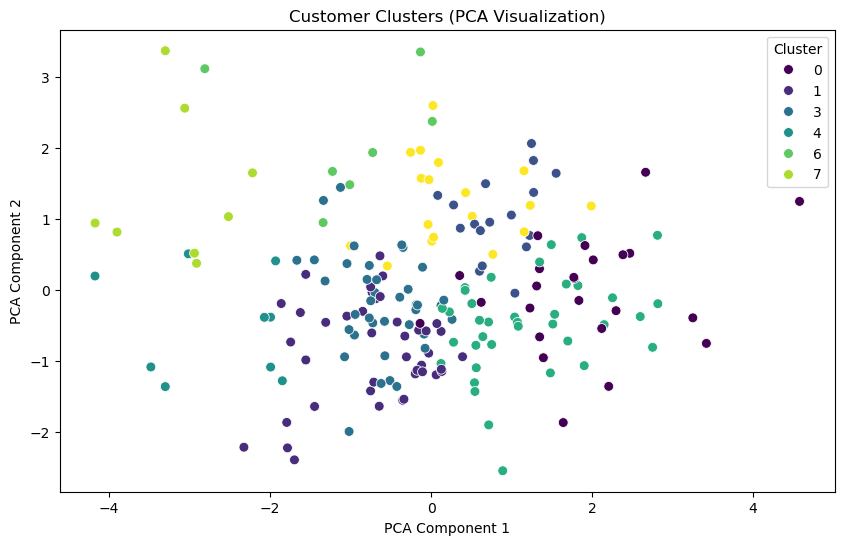

In [11]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=final_labels, palette="viridis", s=50)
plt.title("Customer Clusters (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


### Visualizing clusters

In [12]:
# Output metrics
print("Clustering Metrics:")
print(metrics_df)
print(f"\nBest Number of Clusters: {best_n_clusters}")
print(f"Davies-Bouldin Index for Best Clusters: {metrics_df.loc[metrics_df['NumClusters'] == best_n_clusters, 'DBIndex'].values[0]}")

Clustering Metrics:
   NumClusters   DBIndex  SilhouetteScore
0            2  1.541042         0.232282
1            3  1.373618         0.245337
2            4  1.334839         0.227204
3            5  1.236160         0.248237
4            6  1.282049         0.223669
5            7  1.372695         0.203847
6            8  1.226135         0.222840
7            9  1.221295         0.210075
8           10  1.248022         0.219577

Best Number of Clusters: 9
Davies-Bouldin Index for Best Clusters: 1.22129461755441
